In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Setup and read data

In [2]:
skyhook_col_types = {
"tide5id_100m" : str,
"mac_oui" : str,
"ssid" : str,
"lat" : float,
"lon" : float ,
"rq_time" : str, # we parse this as date with parse_dates parameter in read_csv call later
"zcta" : int,
"zcta_city" : str,
"zcta_county" : str,
"zcta_state" : str
}

skyhook_data = pd.read_csv("../data/skyhook/p1059_nau_oui_20210301.csv", dtype=skyhook_col_types, parse_dates=['rq_time'])

Summary statistics of times of measurements and counts.

In [3]:
print(skyhook_data[['rq_time']].describe(datetime_is_numeric=True))

                             rq_time
count                        1291723
mean   2020-09-17 07:06:19.692180224
min              2019-09-07 00:04:19
25%       2020-05-20 19:33:33.500000
50%              2020-10-29 23:15:28
75%       2021-02-21 01:56:43.500000
max              2021-03-07 23:59:52


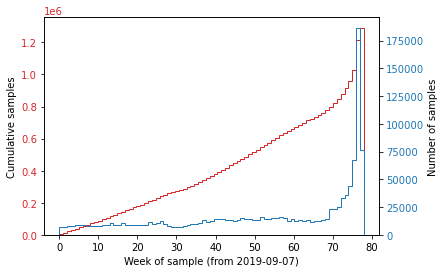

In [4]:

weekly_counts = skyhook_data.resample('7d', on='rq_time')['rq_time'].count()

cdf_color = 'tab:red'
hist_color = 'tab:blue'

num_bin = weekly_counts.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(np.arange(0,num_bin), num_bin, weights=weekly_counts, cumulative=True, histtype='step', color=cdf_color)
cdf_ax.tick_params(axis='y', labelcolor=cdf_color)
plt.ylabel("Cumulative samples")
plt.xlabel("Week of sample (from 2019-09-07)")

hist_ax = cdf_ax.twinx()

hist_ax.hist(np.arange(0,num_bin), num_bin, weights=weekly_counts, histtype='step', color=hist_color)
hist_ax.tick_params(axis='y', labelcolor=hist_color)
plt.ylabel("Number of samples")
plt.show()

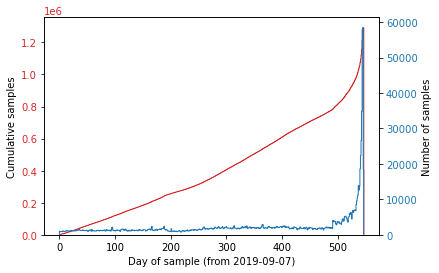

In [5]:

daily_counts = skyhook_data.resample('1d', on='rq_time')['rq_time'].count()

cdf_color = 'tab:red'
hist_color = 'tab:blue'

num_bin = daily_counts.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(np.arange(0,num_bin), num_bin, weights=daily_counts, cumulative=True, histtype='step', color=cdf_color)
cdf_ax.tick_params(axis='y', labelcolor=cdf_color)
plt.ylabel("Cumulative samples")
plt.xlabel("Day of sample (from 2019-09-07)")

hist_ax = cdf_ax.twinx()

hist_ax.hist(np.arange(0,num_bin), num_bin, weights=daily_counts, histtype='step', color=hist_color)
hist_ax.tick_params(axis='y', labelcolor=hist_color)
plt.ylabel("Number of samples")
plt.show()

In [6]:
area_data = skyhook_data['tide5id_100m'].groupby(skyhook_data['tide5id_100m']).count().sort_values()
frequency_count_measurement = area_data.groupby(area_data).count()

area_data.describe()


count    85510.000000
mean        15.106105
std         90.261841
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max      17363.000000
Name: tide5id_100m, dtype: float64

In [7]:
frequency_count_measurement.describe()

count      598.000000
mean       142.993311
std       1266.646053
min          1.000000
25%          1.000000
50%          2.000000
75%         11.000000
max      26625.000000
Name: tide5id_100m, dtype: float64

Creating a CDF of non-empty tiles

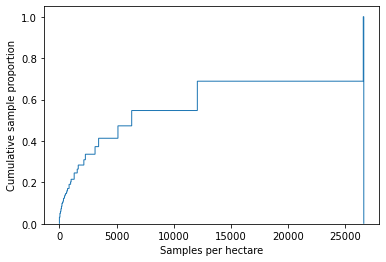

In [8]:
num_bin = frequency_count_measurement.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(frequency_count_measurement, num_bin, weights=frequency_count_measurement, density=True, cumulative=True, histtype='step')
plt.ylabel("Cumulative sample proportion")
plt.xlabel("Samples per hectare")

plt.show()

Unfortunately we can not derive empty tiles from this method because of the arbitrary nature of the tile IDs, so we will calculate the approximate proportion by finding our total measurement area and subtracting the area which contains measurements from our data set.